In [34]:
"""

Java/HDFS logs

t1 INFO added user abc
t2 ERROR deleted user xyz

Elastic search

t1 | INFO | added user abc
t2 | ERROR | deleted user xyz

ML 

Events

event_id | event
e1 | added user <>
e2 | deleted user <>


Logs

0-5 mins - tw1
t1 | INFO | added user 1
t2 | ERROR | deleted user 2
t3 | INFO | added user 3
t4 | ERROR | deleted user 4
t5 | INFO | added user 5


6-10 mins
t6 | ERROR | deleted user 6
t7 | INFO | added user 7
t8 | ERROR | deleted user 8

11-15 mins
t9 | INFO | added user 9
t10 | ERROR | deleted user 0


Log_summary


time_window_id | count_info | count_error | count_e1 | count_e2
tw1 | 3 | 2 | 3 | 2
tw2 | 1 | 2 | 1 | 2
tw3 | 1 | 1 | 1 | 1

"""

'\n\nJava/HDFS logs\n\nt1 INFO added user abc\nt2 ERROR deleted user xyz\n\nElastic search\n\nt1 | INFO | added user abc\nt2 | ERROR | deleted user xyz\n\nML \n\nEvents\n\nevent_id | event\ne1 | added user <>\ne2 | deleted user <>\n\n\nLogs\n\n0-5 mins - tw1\nt1 | INFO | added user 1\nt2 | ERROR | deleted user 2\nt3 | INFO | added user 3\nt4 | ERROR | deleted user 4\nt5 | INFO | added user 5\n\n\n6-10 mins\nt6 | ERROR | deleted user 6\nt7 | INFO | added user 7\nt8 | ERROR | deleted user 8\n\n11-15 mins\nt9 | INFO | added user 9\nt10 | ERROR | deleted user 0\n\n\nLog_summary\n\n\ntime_window_id | count_info | count_error | count_e1 | count_e2\ntw1 | 3 | 2 | 3 | 2\ntw2 | 1 | 2 | 1 | 2\ntw3 | 1 | 1 | 1 | 1\n\n'

In [35]:
import datetime
    
end_time = datetime.datetime.utcnow()
start_time = end_time - datetime.timedelta(days = 1)

print(start_time, end_time)

2023-04-18 22:07:57.970139 2023-04-19 22:07:57.970139


In [36]:
# Elasticsearch connection

from elasticsearch import Elasticsearch

AWS_HOSTNAME = 'http://ec2-13-57-247-5.us-west-1.compute.amazonaws.com'
ELASTIC_PORT = 9200

es = Elasticsearch(["{}:{}".format(AWS_HOSTNAME, ELASTIC_PORT)],timeout=30)

/tmp/ipykernel_9190/1591255818.py:8: DeprecationWarning: The 'timeout' parameter is deprecated in favor of 'request_timeout'
  es = Elasticsearch(["{}:{}".format(AWS_HOSTNAME, ELASTIC_PORT)],timeout=30)


In [37]:
import os

def fetch_logs(start_time, end_time):

    search_body = {
        "query": {
            "range": {
                "@timestamp": {
                    "gte": start_time,
                    "lte": end_time
                }
            }
        }
    }
    search_result = es.search(index='spring-elk-logs', body=search_body)
    hits = search_result['hits']['hits']    
    log_dir = "data/unstructured/Java/"
    log_file_path = os.path.join(log_dir, f"application.log")
    with open(log_file_path, 'a') as log_file:
        for hit in hits:
            log_file.write(f"{hit['_source']['message']}\n")
    return log_file_path

log_file_path = fetch_logs(start_time, end_time)
print(f"Logs fetched from elasticsearch and file is generated  at {log_file_path}")

Logs fetched from elasticsearch and file is generated  at data/unstructured/Java/application.log


/tmp/ipykernel_9190/828916574.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  search_result = es.search(index='spring-elk-logs', body=search_body)
/tmp/ipykernel_9190/828916574.py:15: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  search_result = es.search(index='spring-elk-logs', body=search_body)


In [38]:
import pandas as pd
import os
import numpy as np
import re
from sklearn.utils import shuffle
from collections import OrderedDict
import sys
sys.path.append('../')
from log_parser import Drain

log_file_path = 'data/unstructured/Java/'
#label_file_name = 'data/unstructured/HDFS/anomaly_label.csv'
unstructured_log_filename = 'application.log'
structured_log_file_path = 'data/structured/Java/'
structured_log_filename = 'application.log_structured.csv'


def parseLog(log_file_path, log_file_name, structured_log_file_path, log_type):
    if log_type == 'HDFS':
        log_format = '<Date> <Time> <Pid> <Level> <Component>: <Content>'
        
    if log_type == 'Java':
        log_format = '<Date> <Time> <Pid> <Level> <Component> - <Content>'

    # Regular expression list for optional preprocessing (default: [])
    regex      = [
        r'blk_(|-)[0-9]+' , # block id
        r'(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)', # IP
        r'(?<=[^A-Za-z0-9])(\-?\+?\d+)(?=[^A-Za-z0-9])|[0-9]+$', # Numbers
    ]
    st         = 0.5  # Similarity threshold
    depth      = 4  # Depth of all leaf nodes

    parser = Drain.LogParser(log_format, indir=log_file_path, outdir=structured_log_file_path,  depth=depth, st=st, rex=regex)
    parser.parse(log_file_name)

## parse the logs - convert unstructured to structured log
parseLog(log_file_path, unstructured_log_filename, structured_log_file_path, 'Java')
    

## read structured log 
print("Loading", structured_log_file_path+structured_log_filename)
structured_log = pd.read_csv(structured_log_file_path+structured_log_filename, engine='c', na_filter=False, memory_map=True)

structured_log

Parsing file: data/unstructured/Java/application.log
Processed 8.0% of log lines.
Processed 16.0% of log lines.
Processed 23.9% of log lines.
Processed 31.9% of log lines.
Processed 39.9% of log lines.
Processed 47.9% of log lines.
Processed 55.9% of log lines.
Processed 63.8% of log lines.
Processed 71.8% of log lines.
Processed 79.8% of log lines.
Processed 87.8% of log lines.
Processed 95.8% of log lines.
Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:01.440018]
Loading data/structured/Java/application.log_structured.csv


,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,ParameterList
0,1,29-03-2023,09:11:24.916,[http-nio-8080-exec-1],INFO,c.b.management.services.UserService.getAllCards,/home/ubuntu/Anomaly-Detection/Bank-Management...,d73f95b5,/home/ubuntu/Anomaly-Detection/Bank-Management...,[]
1,2,29-03-2023,09:11:26.040,[http-nio-8080-exec-3],INFO,c.b.management.services.UserService.createCard,Inside create card...,b23d1fae,Inside <*> card...,['create']
2,3,29-03-2023,09:11:27.145,[http-nio-8080-exec-5],INFO,c.b.management.services.UserService.updateCard,Inside update card...,b23d1fae,Inside <*> card...,['update']
3,4,29-03-2023,09:11:27.146,[http-nio-8080-exec-5],INFO,c.b.management.services.UserService.updateCard,Card object with ID 94 has been updated succes...,94ca10d1,Card object with ID <*> has been updated succe...,['94']
4,5,29-03-2023,09:11:28.219,[http-nio-8080-exec-7],INFO,c.b.management.services.UserService.deleteCard,Inside delete card...,b23d1fae,Inside <*> card...,['delete']
...,...,...,...,...,...,...,...,...,...,...
12525,12526,19-04-2023,21:28:25.369,[main],INFO,com.bank.management.ElkApplication.logStartupP...,"No active profile set, falling back to default...",44bf45f7,"No active profile set, falling back to default...",[]
12526,12527,19-04-2023,21:28:30.661,[main],INFO,com.bank.management.ElkApplication.logStarted,Started ElkApplication in 7.173 seconds (JVM r...,e811627e,Started ElkApplication in <*>.<*> seconds (JVM...,"['7.173', '8.758']"
12527,12528,19-04-2023,21:28:25.357,[main],INFO,com.bank.management.ElkApplication.logStarting,Starting ElkApplication v0.0.1-SNAPSHOT using ...,1446c0e4,Starting ElkApplication v0.<*>.<*>-SNAPSHOT us...,"['0.1', '11', '0.18', '172', '31-3-241', '2029..."
12528,12529,19-04-2023,21:28:25.369,[main],INFO,com.bank.management.ElkApplication.logStartupP...,"No active profile set, falling back to default...",44bf45f7,"No active profile set, falling back to default...",[]


In [39]:
# Filter null dates

structured_log = structured_log[structured_log['Date'] != '']
structured_log.head()

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,ParameterList
0,1,29-03-2023,09:11:24.916,[http-nio-8080-exec-1],INFO,c.b.management.services.UserService.getAllCards,/home/ubuntu/Anomaly-Detection/Bank-Management...,d73f95b5,/home/ubuntu/Anomaly-Detection/Bank-Management...,[]
1,2,29-03-2023,09:11:26.040,[http-nio-8080-exec-3],INFO,c.b.management.services.UserService.createCard,Inside create card...,b23d1fae,Inside <*> card...,['create']
2,3,29-03-2023,09:11:27.145,[http-nio-8080-exec-5],INFO,c.b.management.services.UserService.updateCard,Inside update card...,b23d1fae,Inside <*> card...,['update']
3,4,29-03-2023,09:11:27.146,[http-nio-8080-exec-5],INFO,c.b.management.services.UserService.updateCard,Card object with ID 94 has been updated succes...,94ca10d1,Card object with ID <*> has been updated succe...,['94']
4,5,29-03-2023,09:11:28.219,[http-nio-8080-exec-7],INFO,c.b.management.services.UserService.deleteCard,Inside delete card...,b23d1fae,Inside <*> card...,['delete']


In [40]:
def fill_zeros(x):
    if len(str(x)) < 6:
        return str(x).zfill(6)
    else:
        return str(x)
    
structured_log['Date'] = structured_log['Date'].apply(fill_zeros)
structured_log['Time'] = structured_log['Time'].apply(fill_zeros)

structured_log.loc[:,'Date'] = pd.to_datetime(structured_log.Date.astype(str)+' '+structured_log.Time.astype(str), format="%d-%m-%Y %H:%M:%S.%f")
# structured_log.set_index("Date", inplace=True)

structured_log = structured_log.drop(columns=['Time'])

structured_log.head()

# structured_log['EventTemplate'].nunique()

,LineId,Date,Pid,Level,Component,Content,EventId,EventTemplate,ParameterList
0,1,2023-03-29 09:11:24.916,[http-nio-8080-exec-1],INFO,c.b.management.services.UserService.getAllCards,/home/ubuntu/Anomaly-Detection/Bank-Management...,d73f95b5,/home/ubuntu/Anomaly-Detection/Bank-Management...,[]
1,2,2023-03-29 09:11:26.040,[http-nio-8080-exec-3],INFO,c.b.management.services.UserService.createCard,Inside create card...,b23d1fae,Inside <*> card...,['create']
2,3,2023-03-29 09:11:27.145,[http-nio-8080-exec-5],INFO,c.b.management.services.UserService.updateCard,Inside update card...,b23d1fae,Inside <*> card...,['update']
3,4,2023-03-29 09:11:27.146,[http-nio-8080-exec-5],INFO,c.b.management.services.UserService.updateCard,Card object with ID 94 has been updated succes...,94ca10d1,Card object with ID <*> has been updated succe...,['94']
4,5,2023-03-29 09:11:28.219,[http-nio-8080-exec-7],INFO,c.b.management.services.UserService.deleteCard,Inside delete card...,b23d1fae,Inside <*> card...,['delete']


In [41]:
# TODO: Cleaning: Remove rows and colums with count 0 (no data present)



In [42]:
# Adding relevant columns to the dataframe
LOG_LEVELS = ['WARN', 'INFO', 'DEBUG', 'TRACE', 'ERROR', 'FATAL']
df_grouped = structured_log.groupby(pd.Grouper(key='Date', freq='5Min',closed='right',label='right')).agg(
    total_msgs=pd.NamedAgg(column="Content", aggfunc="count"),    
).reset_index()

for level in LOG_LEVELS:
    df_grouped[level + '_count'] = 0

for event_id in structured_log['EventId'].unique():
    df_grouped[event_id + '_count'] = 0

df_grouped.head()

,Date,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,d73f95b5_count,b23d1fae_count,...,f6b586ef_count,c0731fc8_count,81f0209d_count,e9469db0_count,54637d32_count,80abedaf_count,3d9f514d_count,1446c0e4_count,44bf45f7_count,e811627e_count
0,2023-03-29 09:15:00,354,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-03-29 09:20:00,507,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023-03-29 09:25:00,496,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-03-29 09:30:00,492,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-03-29 09:35:00,506,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Populating all the log level counts
df_grouped_logLevel = structured_log.groupby([pd.Grouper(key='Date', freq='5Min',closed='right',label='right'), 'Level']).agg(
    count=pd.NamedAgg(column="Level", aggfunc="count"),    
).reset_index()

for row in df_grouped_logLevel.itertuples():
    df_grouped.loc[df_grouped['Date'] == row.Date, row.Level + '_count'] = row.count

df_grouped.head()

,Date,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,d73f95b5_count,b23d1fae_count,...,f6b586ef_count,c0731fc8_count,81f0209d_count,e9469db0_count,54637d32_count,80abedaf_count,3d9f514d_count,1446c0e4_count,44bf45f7_count,e811627e_count
0,2023-03-29 09:15:00,354,0,354,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-03-29 09:20:00,507,0,507,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023-03-29 09:25:00,496,0,496,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-03-29 09:30:00,492,0,492,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-03-29 09:35:00,506,0,506,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Populating all the event id counts
df_grouped_eventId = structured_log.groupby([pd.Grouper(key='Date', freq='5Min',closed='right',label='right'), 'EventId']).agg(
    count=pd.NamedAgg(column="EventId", aggfunc="count"),    
).reset_index()

for row in df_grouped_eventId.itertuples():
    df_grouped.loc[df_grouped['Date'] == row.Date, row.EventId + '_count'] = row.count

df_grouped

,Date,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,d73f95b5_count,b23d1fae_count,...,f6b586ef_count,c0731fc8_count,81f0209d_count,e9469db0_count,54637d32_count,80abedaf_count,3d9f514d_count,1446c0e4_count,44bf45f7_count,e811627e_count
0,2023-03-29 09:15:00,354,0,354,0,0,0,0,41,118,...,35,40,41,28,13,0,0,0,0,0
1,2023-03-29 09:20:00,507,0,507,0,0,0,0,56,152,...,62,56,71,54,17,0,0,0,0,0
2,2023-03-29 09:25:00,496,0,496,0,0,0,0,51,166,...,44,51,60,46,14,0,0,0,0,0
3,2023-03-29 09:30:00,492,0,492,0,0,0,0,62,170,...,49,62,46,38,8,0,0,0,0,0
4,2023-03-29 09:35:00,506,0,506,0,0,0,0,45,163,...,61,45,69,53,16,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6191,2023-04-19 21:10:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6192,2023-04-19 21:15:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6193,2023-04-19 21:20:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6194,2023-04-19 21:25:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#Manually labelling anomalous window to compare later with model output

df_grouped['anomaly_manual'] = (df_grouped['ERROR_count'] > 0).astype(int)

In [46]:
# Filtering only the feature columns

feature_cols = list(df_grouped.columns);
feature_cols.remove('Date')

data_with_feature_columns = df_grouped[feature_cols]

In [47]:
#Scaling the values of the input data

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

data_scaled = min_max_scaler.fit_transform(data_with_feature_columns)
data_scaled = pd.DataFrame(data_scaled, columns=feature_cols)

data_scaled

,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,d73f95b5_count,b23d1fae_count,94ca10d1_count,...,c0731fc8_count,81f0209d_count,e9469db0_count,54637d32_count,80abedaf_count,3d9f514d_count,1446c0e4_count,44bf45f7_count,e811627e_count,anomaly_manual
0,0.695481,0.0,0.695481,0.0,0.0,0.0,0.0,0.640625,0.634409,0.584615,...,0.625000,0.577465,0.437500,0.764706,0.0,0.0,0.0,0.0,0.0,0.0
1,0.996071,0.0,0.996071,0.0,0.0,0.0,0.0,0.875000,0.817204,0.600000,...,0.875000,1.000000,0.843750,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.974460,0.0,0.974460,0.0,0.0,0.0,0.0,0.796875,0.892473,0.984615,...,0.796875,0.845070,0.718750,0.823529,0.0,0.0,0.0,0.0,0.0,0.0
3,0.966601,0.0,0.966601,0.0,0.0,0.0,0.0,0.968750,0.913978,0.876923,...,0.968750,0.647887,0.593750,0.470588,0.0,0.0,0.0,0.0,0.0,0.0
4,0.994106,0.0,0.994106,0.0,0.0,0.0,0.0,0.703125,0.876344,0.830769,...,0.703125,0.971831,0.828125,0.941176,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6191,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6192,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6193,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6194,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


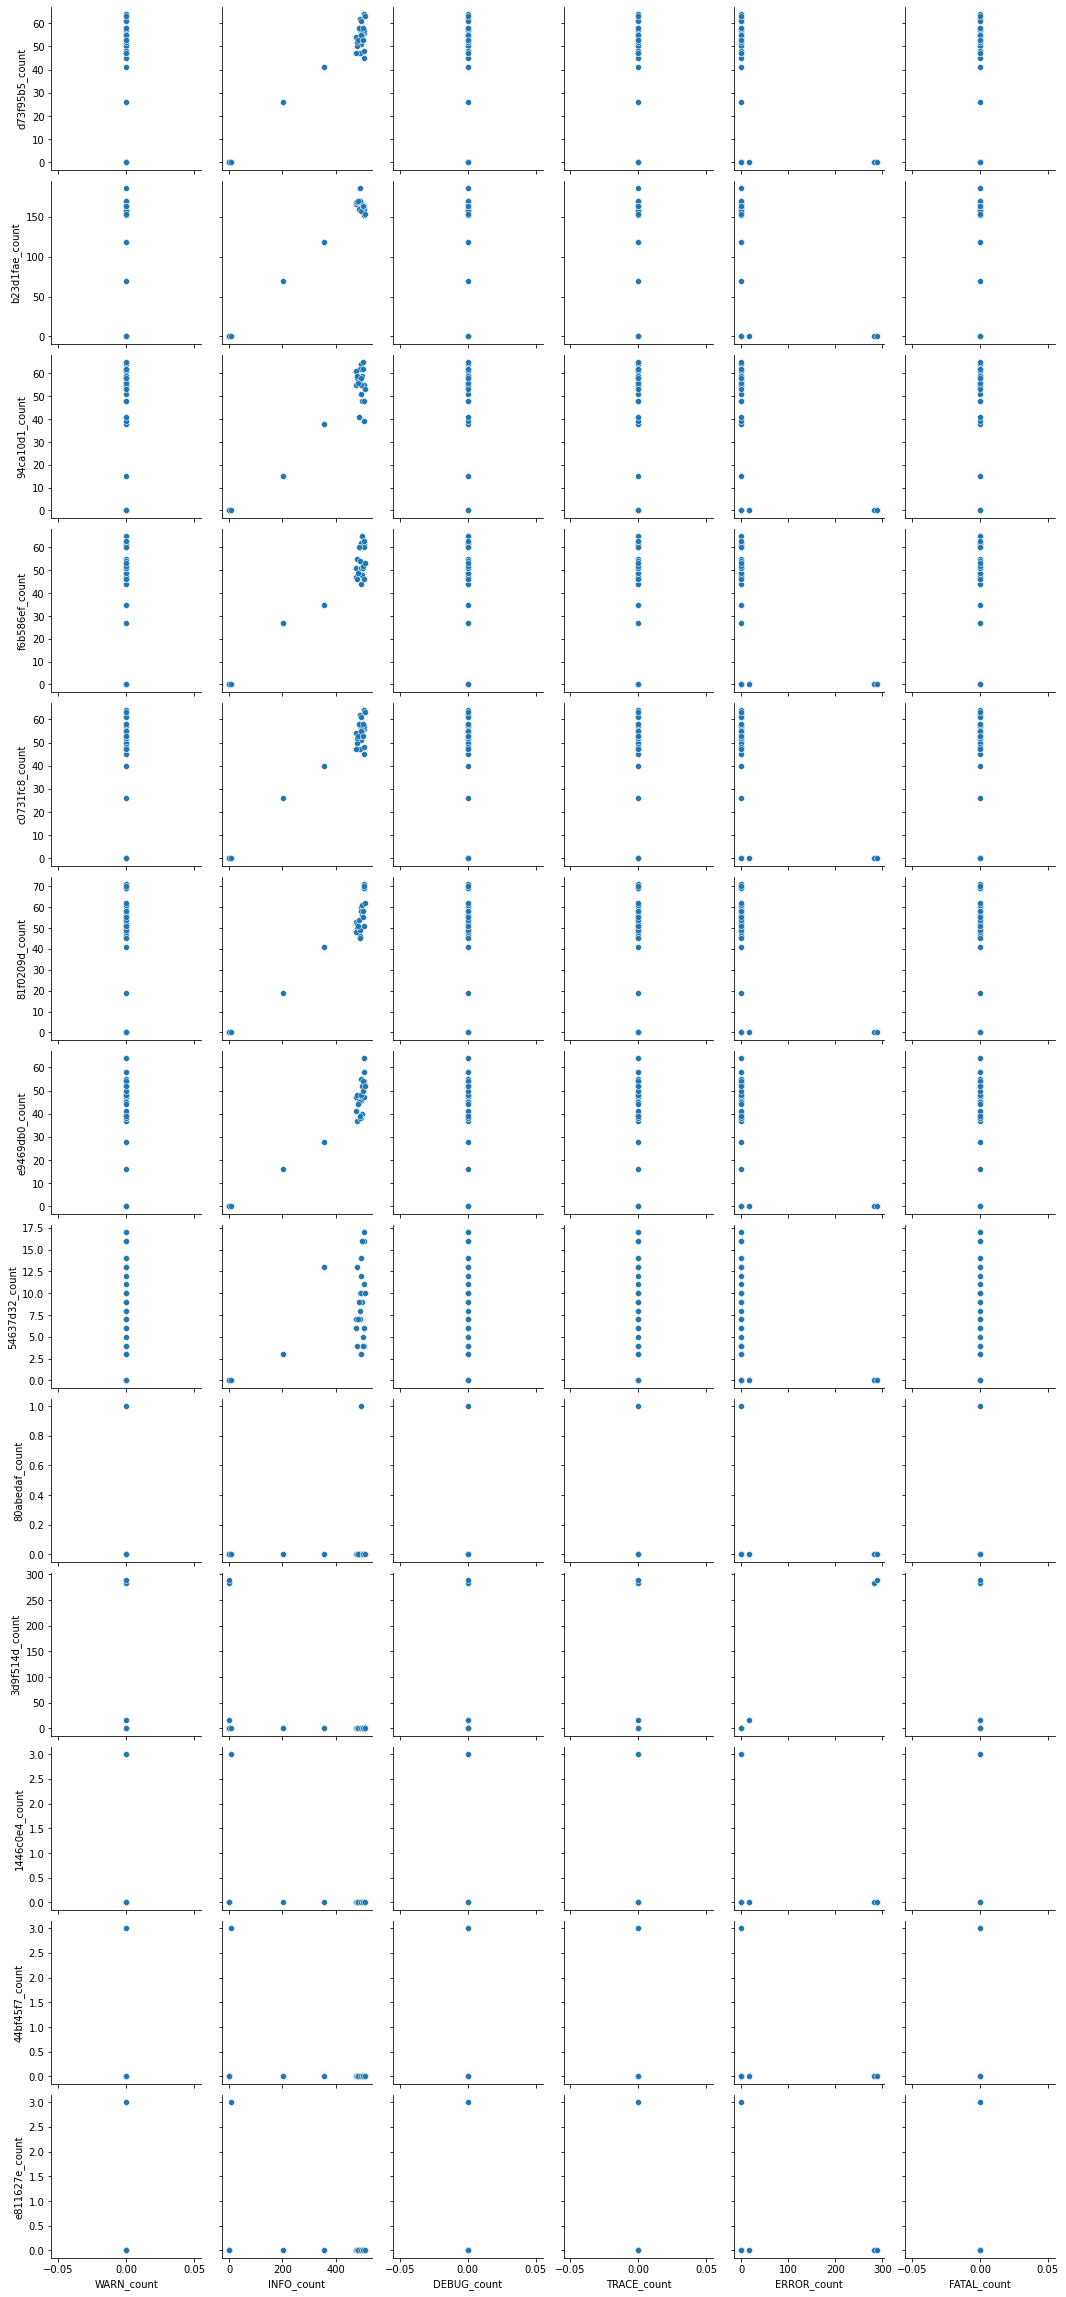

In [48]:
# Visualizing the relationship between log_levels and the event_ids

import seaborn as sns

all_columns = list(df_grouped.columns)
log_level_columns = all_columns[2:8]
event_id_columns = all_columns[8:-1]

sns.pairplot(df_grouped, y_vars= event_id_columns,
                  x_vars= log_level_columns)

In [49]:
# Applying Kmeans clustering to different values of k (1-15)

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
RANDOM_STATE = 123

cluster_check_range = range(1, 15)

kmeans = [None] * (len(cluster_check_range) + 1)
scores = [0] * (len(cluster_check_range) + 1)
for i in cluster_check_range:
    if i == 0:
        continue
    kmeans[i] = KMeans(n_clusters=i, random_state=RANDOM_STATE).fit(data_scaled) 
    scores[i] = kmeans[i].score(data_scaled)

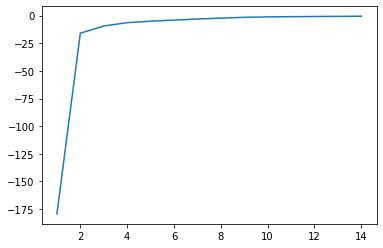

In [50]:
# Finding the elbow point

fig, ax = plt.subplots()
ax.plot(cluster_check_range, scores[1:])
plt.show()

In [51]:
# Selecting appropriate k. Here we chose k = 8

k = 2
cluster_model = kmeans[k]

df_grouped['cluster'] = cluster_model.predict(data_scaled)
df_grouped['cluster'].value_counts()
df = df_grouped['cluster'].value_counts().rename_axis('Cluster number').reset_index(name='counts')
df

,Cluster number,counts
0,0,6172
1,1,24


In [52]:
# final_data - df_grouped
# data_new - data_scaled

/home/sandesh/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sandesh/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6196 samples in 0.000s...
[t-SNE] Computed neighbors for 6196 samples in 0.542s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6196
[t-SNE] Computed conditional probabilities for sample 2000 / 6196
[t-SNE] Computed conditional probabilities for sample 3000 / 6196
[t-SNE] Computed conditional probabilities for sample 4000 / 6196
[t-SNE] Computed conditional probabilities for sample 5000 / 6196
[t-SNE] Computed conditional probabilities for sample 6000 / 6196
[t-SNE] Computed conditional probabilities for sample 6196 / 6196
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 123.767433
[t-SNE] KL divergence after 300 iterations: 3.650929


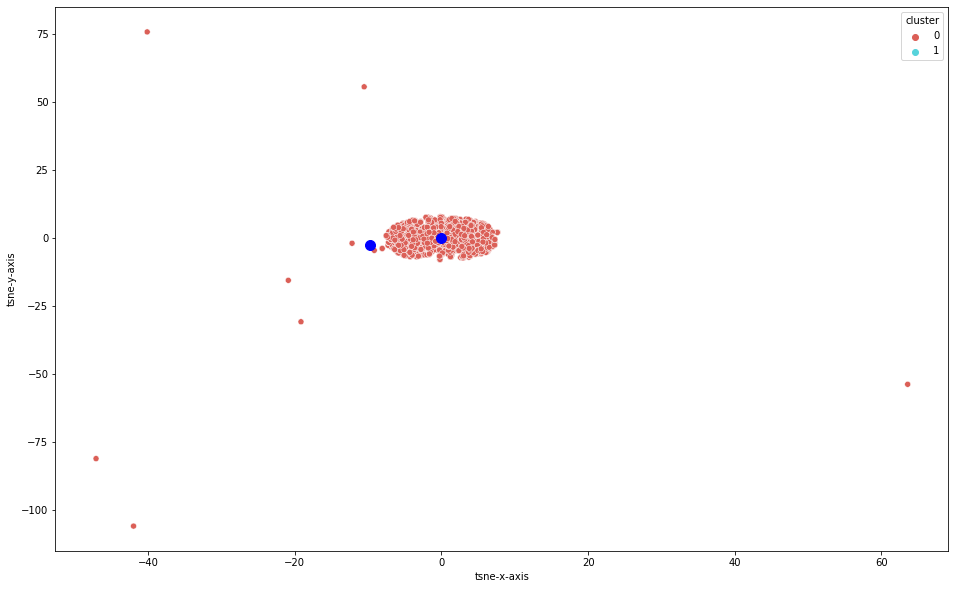

In [53]:
# Applying tSNE to visualise data in 2D

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=RANDOM_STATE)
tsne_results = tsne.fit_transform(data_scaled)

df_grouped['tsne-x-axis'] = tsne_results[:,0]
df_grouped['tsne-y-axis'] = tsne_results[:,1]
df_grouped

tsne_cluster = df_grouped.groupby('cluster').agg({'tsne-x-axis':'mean', 'tsne-y-axis':'mean'}).reset_index()

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-x-axis", y="tsne-y-axis",
    hue="cluster",
    palette=sns.color_palette("hls", k),
    data=df_grouped,
    legend="full",
    alpha=1
)

plt.scatter(x="tsne-x-axis", y="tsne-y-axis", data=tsne_cluster, s=100, c='b')
plt.show()

/tmp/ipykernel_9190/1709323777.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  total_distance = pd.Series()


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 6.169e+03,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

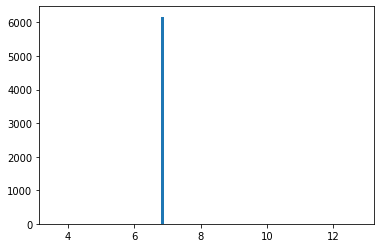

In [54]:
# Plotting histogram of sum_squared_distances of all points from the center of clusters

def get_ssd(data, cluster_model, feature_cols):
    centers = cluster_model.cluster_centers_
    points = np.asarray(data[feature_cols])
    total_distance = pd.Series()
    for i in range(len(points)):
        total_distance.at[i] = get_distance(centers, points, i)
    return total_distance  

def get_distance(centers, points, i):
    distance = 0
    for j in range(len(centers)):
        d = np.linalg.norm(points[i] - centers[j])
        distance += d**2
    return distance


centers = cluster_model.cluster_centers_
points = np.asarray(data_scaled)

df_grouped['ssd'] = get_ssd(data_scaled, cluster_model, feature_cols)

plt.hist(df_grouped['ssd'], bins=100)

<AxesSubplot:xlabel='tsne-x-axis', ylabel='tsne-y-axis'>

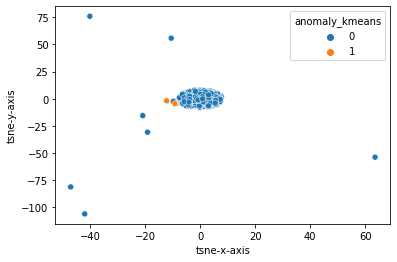

In [55]:
# Setting cutoff to ssd for anomaly

cutoff = 8.5
df_grouped['anomaly_kmeans'] = (df_grouped['ssd'] >= cutoff).astype(int)

sns.scatterplot(
    x="tsne-x-axis", y="tsne-y-axis",
    hue="anomaly_kmeans",
    data=df_grouped,
    legend="full",
    alpha=1
)


In [56]:
# Listing anomalous rows according to k-means

df_grouped.loc[df_grouped['anomaly_kmeans']==1]

,Date,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,d73f95b5_count,b23d1fae_count,...,3d9f514d_count,1446c0e4_count,44bf45f7_count,e811627e_count,anomaly_manual,cluster,tsne-x-axis,tsne-y-axis,ssd,anomaly_kmeans
1,2023-03-29 09:20:00,507,0,507,0,0,0,0,56,152,...,0,0,0,0,0,1,-9.817292,-2.535491,8.518644,1
20,2023-03-29 10:55:00,493,0,493,0,0,0,0,55,157,...,0,0,0,0,0,1,-9.817902,-2.535632,8.988893,1
107,2023-03-29 18:10:00,283,0,0,0,0,283,0,0,0,...,283,0,0,0,1,0,-8.084143,-3.860700,12.217993,1
108,2023-03-29 18:15:00,289,0,0,0,0,289,0,0,0,...,289,0,0,0,1,0,-8.083808,-3.860488,12.386181,1
109,2023-03-29 18:20:00,17,0,0,0,0,17,0,0,0,...,17,0,0,0,1,0,-9.168159,-4.561540,8.785263,1
6195,2023-04-19 21:30:00,9,0,9,0,0,0,0,0,0,...,0,3,3,3,0,0,-12.196874,-1.945397,12.766752,1


/home/sandesh/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/sandesh/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Date,total_msgs,WARN_count,INFO_count,DEBUG_count,TRACE_count,ERROR_count,FATAL_count,d73f95b5_count,b23d1fae_count,...,1446c0e4_count,44bf45f7_count,e811627e_count,anomaly_manual,cluster,tsne-x-axis,tsne-y-axis,ssd,anomaly_kmeans,anomaly_isolated
0,2023-03-29 09:15:00,354,0,354,0,0,0,0,41,118,...,0,0,0,0,1,-9.789671,-2.530802,4.516239,0,1
1,2023-03-29 09:20:00,507,0,507,0,0,0,0,56,152,...,0,0,0,0,1,-9.817292,-2.535491,8.518644,1,1
2,2023-03-29 09:25:00,496,0,496,0,0,0,0,51,166,...,0,0,0,0,1,-9.817163,-2.535473,7.432226,0,1
3,2023-03-29 09:30:00,492,0,492,0,0,0,0,62,170,...,0,0,0,0,1,-9.817205,-2.535487,6.992487,0,1
4,2023-03-29 09:35:00,506,0,506,0,0,0,0,45,163,...,0,0,0,0,1,-9.817279,-2.535486,8.082407,0,1
5,2023-03-29 09:40:00,481,0,481,0,0,0,0,50,168,...,0,0,0,0,1,-9.816957,-2.535438,6.841595,0,1
6,2023-03-29 09:45:00,493,0,493,0,0,0,0,61,158,...,0,0,0,0,1,-9.817175,-2.535480,7.384305,0,1
7,2023-03-29 09:50:00,497,0,497,0,0,0,0,53,166,...,0,0,0,0,1,-9.817096,-2.535456,7.734224,0,1
8,2023-03-29 09:55:00,476,0,476,0,0,0,0,54,166,...,0,0,0,0,1,-9.817060,-2.535462,6.377497,0,1
9,2023-03-29 10:00:00,492,0,492,0,0,0,0,47,186,...,0,0,0,0,1,-9.817171,-2.535475,6.756411,0,1


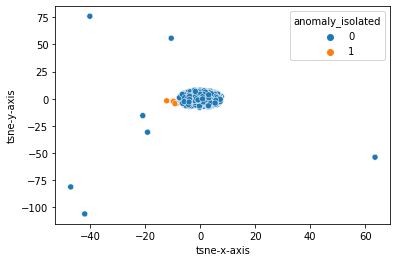

In [57]:
# Clustering using Isolated forests

from sklearn.ensemble import IsolationForest

outlier_fraction = 0.03

model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=RANDOM_STATE, contamination=outlier_fraction)
model.fit(data_scaled)

df_grouped['anomaly_isolated'] = pd.Series(model.predict(data_scaled))
df_grouped['anomaly_isolated'] = df_grouped['anomaly_isolated'].map( {1: 0, -1: 1} )

sns.scatterplot(
    x="tsne-x-axis", y="tsne-y-axis",
    hue="anomaly_isolated",
    data=df_grouped,
    legend="full",
    alpha=1
)

df_grouped.loc[df_grouped['anomaly_isolated']==1]

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay, recall_score

def calculate_metrics(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    sensitivity = cf[0,0]/(cf[:,0].sum())
    specificity = cf[1,1]/(cf[:,1].sum())
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='binary')
    return {'f1_score': f1, 'accuracy': acc, 'sensitivity': sensitivity, 'specificity': specificity, 'recall': recall}

anomaly_manual = df_grouped['anomaly_manual']
anomaly_isolated = df_grouped['anomaly_isolated']
anomaly_kmeans = df_grouped['anomaly_kmeans']

kmeans_metrics = calculate_metrics(anomaly_manual, anomaly_isolated)
iso_metrics = calculate_metrics(anomaly_manual, anomaly_kmeans)


# Create dataframes from the metrics dictionaries
kmeans_df = pd.DataFrame.from_dict(kmeans_metrics, orient='index', columns=['K-means'])
iso_df = pd.DataFrame.from_dict(iso_metrics, orient='index', columns=['Isolation Forest'])

# Combine the dataframes
metrics_df = pd.concat([kmeans_df, iso_df], axis=1)

# Print the dataframe
print(metrics_df)



              K-means  Isolation Forest
f1_score     0.187500          0.666667
accuracy     0.995804          0.999516
sensitivity  1.000000          1.000000
specificity  0.103448          0.500000
recall       1.000000          1.000000


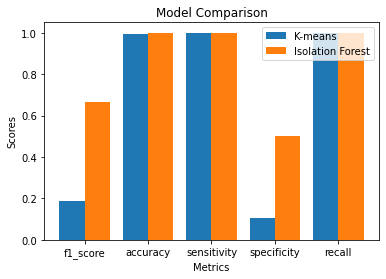

In [59]:
def plot_metric_comparison(kmeans_metrics, iso_metrics):
    fig, ax = plt.subplots()
    ax.bar(kmeans_metrics.keys(), kmeans_metrics.values(), width=-0.4, align='edge', label='K-means')
    ax.bar(iso_metrics.keys(), iso_metrics.values(), width=0.4, align='edge', label='Isolation Forest')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison')
    ax.legend()
    plt.show()


plot_metric_comparison(kmeans_metrics, iso_metrics)

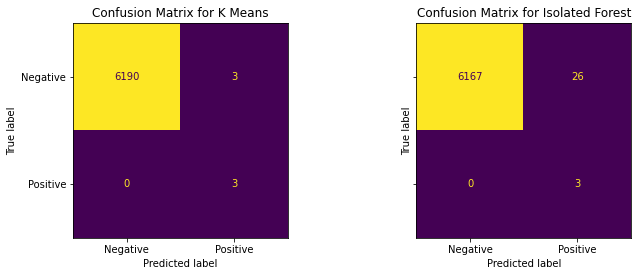

In [60]:
def plot_confusion_matrices(models, true_labels):
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5), sharey='row')
    
    for i, (model_name, y_pred) in enumerate(models.items()):
        cm = confusion_matrix(true_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
        disp.plot(ax=axes[i])
        disp.im_.colorbar.remove()
        disp.ax_.set_title(f"Confusion Matrix for {model_name}")
        
    plt.subplots_adjust(wspace=0.6, hspace=0.01)
   
    plt.show()
    
models = {
    'K Means': df_grouped['anomaly_kmeans'],
    'Isolated Forest': df_grouped['anomaly_isolated']
}

true_labels = df_grouped['anomaly_manual']
plot_confusion_matrices(models, true_labels)

In [61]:
# Saving window results of ML run

interval_row = df_grouped.loc[df_grouped['Date'].idxmax()]

index_name = 'ml-results'

window_summary = {
    'start_time': df_grouped['Date'].max() - datetime.timedelta(minutes = 5),
    'end_time': df_grouped['Date'].max(),
    'k_means_metrics': kmeans_metrics,
    'isolation_forest_metrics': iso_metrics,
    'log_level_counts': interval_row[log_level_columns].to_dict(),
    'template_counts': interval_row[event_id_columns].to_dict(),
    'anomaly_score' : 'TO_DO_1'
    
}

print(window_summary)

es.index(index=index_name, document=window_summary)

{'start_time': Timestamp('2023-04-19 21:25:00'), 'end_time': Timestamp('2023-04-19 21:30:00'), 'k_means_metrics': {'f1_score': 0.1875, 'accuracy': 0.9958037443511943, 'sensitivity': 1.0, 'specificity': 0.10344827586206896, 'recall': 1.0}, 'isolation_forest_metrics': {'f1_score': 0.6666666666666666, 'accuracy': 0.999515816655907, 'sensitivity': 1.0, 'specificity': 0.5, 'recall': 1.0}, 'log_level_counts': {'WARN_count': 0, 'INFO_count': 9, 'DEBUG_count': 0, 'TRACE_count': 0, 'ERROR_count': 0, 'FATAL_count': 0}, 'template_counts': {'d73f95b5_count': 0, 'b23d1fae_count': 0, '94ca10d1_count': 0, 'f6b586ef_count': 0, 'c0731fc8_count': 0, '81f0209d_count': 0, 'e9469db0_count': 0, '54637d32_count': 0, '80abedaf_count': 0, '3d9f514d_count': 0, '1446c0e4_count': 3, '44bf45f7_count': 3, 'e811627e_count': 3}, 'anomaly_score': 'TO_DO_1'}


/tmp/ipykernel_9190/78972482.py:20: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.index(index=index_name, document=window_summary)


ObjectApiResponse({'_index': 'ml-results', '_type': '_doc', '_id': 't0KQm4cBe2VBo8APK11X', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 13, '_primary_term': 3})